# Regularized Linear Regression and Bias v.s. Variance

前半部分练习，使用正则化的线性回归，使用水位变化来预测一个水坝的出水量。

后半部分，通过debug算法来测试偏差与方差的影响

## Regularized Linear Regression

### Visualizing the dataset

This dataset is divided into threes parts:

- A training set that your model will learn on : X, y
- **A cross validation** set for determining the regularization parameter:  Xval, yval
- A test set for evaluating performance. These are "unseen" examples which your model did not see during training: Xtest, ytest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat

In [2]:
def load_data(filename):
    data = loadmat(filename)
    return map(np.ravel, [data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

In [4]:
X.shape, Xval.shape, y.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (21,), (12,), (21,), (21,), (21,))

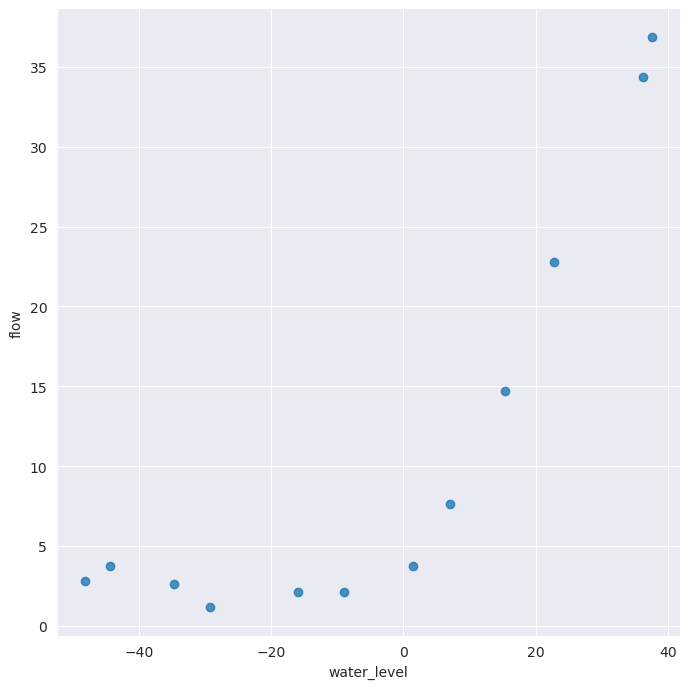

In [5]:
df = pd.DataFrame({'water_level':X, 'flow':y})

import seaborn as sns

sns.lmplot(x="water_level", y="flow", data=df, fit_reg=False, height=7)
plt.show()

<Axes: xlabel='water_level', ylabel='flow'>

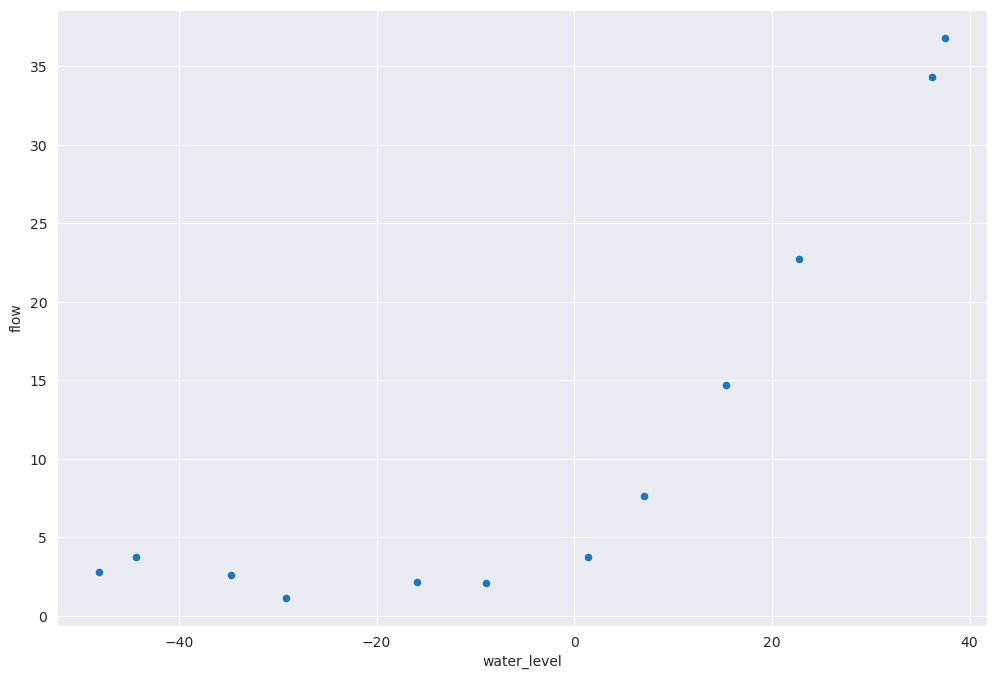

In [6]:
df.plot(kind='scatter', x='water_level', y='flow', figsize=((12,8)))

In [7]:
X, Xval, Xtest = [np.insert(x.reshape(-1, 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

## cost

$$
J(\theta) = \frac{1}{2m}\left( \sum_{i = 1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^2 \right) + \frac{\lambda}{2m}\left( \sum_{j = 1}^{n} \theta_{j}^{2} \right)
$$

In [8]:
def cost(theta, X, y):
    m = X.shape[0]

    error = X @ theta - y

    return error.T @ error / (2 * m)

In [9]:
t = np.ones(X.shape[1])
cost(theta=t, X=X, y=y)

np.float64(303.9515255535976)

In [10]:
def cost_reg(theta, X, y, lambda_=1):
    term = theta.copy()
    term[0] = 0 # 偏置项不参与计算
    reg = term.T @ term
    reg *= lambda_ / (2 * len(X))

    return cost(theta, X, y) + reg

In [11]:
cost_reg(theta=t, X=X, y=y)

np.float64(303.9931922202643)

## gradient

\begin{align*}
\frac{\partial J(\theta)}{\partial \theta_0} &= \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_0^{(i)} \\
\frac{\partial J(\theta)}{\partial \theta_j} &= \left( \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \quad \text{对于 } j \geq 1
\end{align*}

In [12]:
def gradient(theta, X, y):
    return X.T @ (X @ theta - y) / len(X)

In [13]:
gradient(theta=t, X=X, y=y)

array([-15.30301567, 598.16741084])

In [14]:
def gradient_reg(theta, X, y, lambda_=1):
    term = theta.copy()
    term[0] = 0
    term *= lambda_ / len(X)

    return gradient(theta, X, y) + term

In [15]:
gradient_reg(theta=t, X=X, y=y)

array([-15.30301567, 598.25074417])

## Fitting linear regression

In [16]:
import scipy.optimize as opt
def train_linear_reg( X, y, lambda_=1, theta = None):
    if theta is None:
        theta = np.ones(X.shape[1])
    return opt.minimize(fun=cost_reg,
                       x0=theta,
                       args=(X, y, lambda_),
                       method='TNC',
                       jac=gradient_reg,
                       options={'disp': True}).x

在这一部分我们设置lambda为0

In [17]:
final_theta = train_linear_reg(theta=t, X=X, y=y, lambda_=0)

  NIT   NF   F                       GTG
    0    1  3.039515255535976E+02   3.58038434E+05
tnc: fscale = 0.000835613
    1    3  9.299577620594808E+01   1.36988336E+02
tnc: fscale = 0.0427197
    2    5  4.008652214831358E+01   2.25223345E+04
    3    7  2.237390649510891E+01   1.91663765E-13
tnc: |pg| = 1.02481e-05 -> local minimum
    3    7  2.237390649510891E+01   1.91663765E-13
tnc: Local minima reach (|pg| ~= 0)


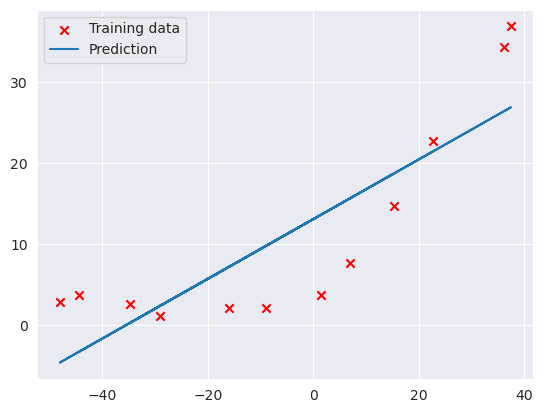

In [18]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data", marker='x', color='red')
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

## Bias-variance

### Learning curves

- 使用训练集的子集来拟合
    - 对于训练集大小i，应该使用前i个示例（即X[1:i,:],y[1:i])
- 训练误差不包括常规化项
    - 在计算train error and cross validation error时设置$\lambda =0$

In [19]:
train_cost, cross_validation_cost = [], []

In [20]:
for i in range(1, len(X) + 1):
    res = train_linear_reg(X=X[:i, :], y=y[:i], lambda_=0)

    tc = cost_reg(theta=res, X=X[:i, :], y=y[:i], lambda_=0)
    train_cost.append(tc)
    cv = cost_reg(theta=res, X=Xval, y=yval, lambda_=0)
    cross_validation_cost.append(cv)

  NIT   NF   F                       GTG
    0    1  1.457106922645887E+02   7.43067003E+04
tnc: fscale = 0.00183424
    1    3  8.631534185484672E-18   4.40174166E-15
tnc: |pg| = 3.61706e-05 -> local minimum
    1    3  8.631534185484672E-18   4.40174166E-15
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.878623740891748E+02   3.18073041E+05
tnc: fscale = 0.000886557
    1    3  2.004821342908418E-01   3.16698305E-02
tnc: fscale = 2.80962
    2    5  1.406351957431711E-04   1.55393840E-01
    3    7  1.198297373799073E-17   1.11887202E-17
tnc: |pg| = 1.19054e-09 -> local minimum
    3    7  1.198297373799073E-17   1.11887202E-17
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.932434806358119E+02   1.68157035E+05
tnc: fscale = 0.00121931
    1    3  8.863206576484284E+01   1.68991145E+02
tnc: fscale = 0.0384625
    2    5  4.163141390502957E+01   3.39442373E+04
    3    7  3.286595045501271E+00   1.93

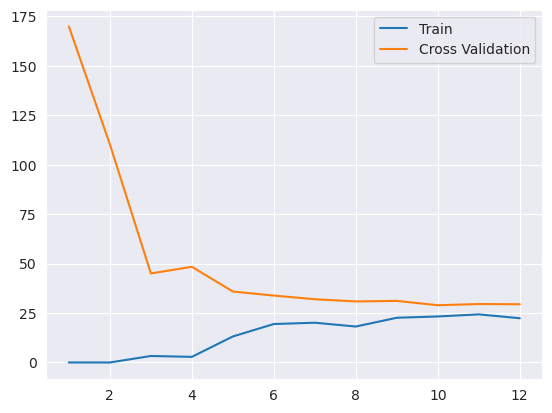

In [21]:
plt.plot(np.arange(1, len(X)+1), train_cost, label='Train')
plt.plot(np.arange(1, len(X)+1), cross_validation_cost, label='Cross Validation')
plt.legend(loc=1)
plt.show()

This reflects a high bias problem in the model. 因为训练集的数据太简单了

##  Polynomial regression
**多项式回归**

\begin{align*}
h_\theta(x) &= \theta_0 + \theta_1 \ast (\text{waterLevel}) + \theta_2 \ast (\text{waterLevel})^2 + \cdots + \theta_p \ast (\text{waterLevel})^p \\
            &= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_p x_p.
\end{align*}